## Analise_Twitters_CVV-Gera_Modelo.ipynb

### Neste programa:
1) Capturamos Twitters do @CVVoficial - param_busca = palavras chaves (suicidio, tristeza, morte, etc);<br>
2) Limpamos os twitters, retirando stopwords, e caracteres desnecessários para análise;<br>
3) Feita a classificação dos twitters lidos.
   
   
Data: 07/08/2020

### ==> CAPTURANDO TWITTERS

In [1]:
lista_de_pesquisa = ["suicidio","tristeza","depressao","morte","solidao"]
param_busca  = " OR ".join(lista_de_pesquisa)
nom_param_busca = "diversos"

In [40]:
# para excluir retweets 
param_busca =   param_busca +  ' -filter:retweets AND -filter:replies'

In [4]:
# pip install twython

In [5]:
from twython import Twython
import time
import csv

In [6]:
def deEmojify(inputString):
    return inputString.encode('cp1252', 'ignore').decode('cp1252')    

In [7]:
#Token do twitter
twitter = Twython('SCkEZ4vzW5DgTZ9VuYf3puxXp','bFR7I6ZzSzF4GO7culGBFbDT5IbBq5v4arlWk7Dc7lYsSf4ciO')

In [8]:
import os
#os.chdir('C:\\Users\\particular\\SERIQUE_TCC\\TCC\\DADOS\\')
#os.getcwd()

In [11]:
# arquivo fica com a data do dia da captura
from datetime import datetime

NomArq = 'twiter_cvv_' + nom_param_busca + '_' + str(datetime.now().strftime('%Y_%m_%d_%H_%M_%S')) + '.csv'

In [12]:
#Busca pelos tweets contendo as palavras chave informadas, pesquisa página do CVV.
#for status in twitter.search(q=param_busca + '(@CVVoficial) lang:pt since:2019-09-24', tweet_mode='extended', count=1000)['statuses']:
for status in twitter.search(q=param_busca, tweet_mode='extended',  count=1000)['statuses']:
    
    user = status['user']['screen_name']  
    text =  deEmojify(status['full_text']).replace('\n', ' ')
    ts = time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(status['created_at'],'%a %b %d %H:%M:%S +0000 %Y'))
    Date = ts                

    with open(NomArq, 'a', newline='', encoding='cp1252') as csvFile:
        row = [user, text, Date, '\n']    
        writer = csv.writer(csvFile, delimiter=";")
        writer.writerow(row)
    csvFile.close()


%%javascript
// run the first 19 cells
var i;
for(i=0; i<19; i++) {
    Jupyter.notebook.execute_cells([i]);
}

// set the global in the 20th cell:
Jupyter.notebook.execute_cells([19]);

// run 2nd through 19th cells again:
for(i=1; i<19; i++) {
    Jupyter.notebook.execute_cells([i]);
}

### ==> LIMPANDO TWITTERS

- Junta todos os arquivos do tipo *.csv que existirem no diretório para dentro de um único arquivo
- Limpa caracteres desnecessários, deleta colunas desnecessárias

In [13]:
import chardet
import emoji
import glob
import nltk
nltk.download('stopwords')
nltk.download('rslp')
import os
import pandas as pd
import re
import regex
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\particular\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\particular\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [14]:
com_stemizacao = 'NAO'

In [15]:
cabecalho = ['Usuario','Texto','Data','lixo']
dataset = pd.read_csv(NomArq,  sep=';', header=None, names=cabecalho, encoding='cp1252')

dataset.head()


,Usuario,Texto,Data,lixo
0,Isaa_Artigas,Quando eu lembro q ainda tenho mais três dias ...,2020-09-02 01:46:57,\n
1,thegealachgorm,Mataram um gatinho de rua de forma maldosa e c...,2020-09-02 01:46:55,\n
2,X1VOIR,eu n sei se vocês sabem mas setembro amarelo é...,2020-09-02 01:46:54,\n
3,ta_kayk,Simplesmente cansei de viver com essa tristeza,2020-09-02 01:46:53,\n
4,Tc0Amanda,Dormir pensando que a tristeza vai embora é um...,2020-09-02 01:46:52,\n


In [16]:
# Expande o tamanho de exibição da coluna de texto
pd.set_option('display.max_colwidth', -1)
dataset.Texto.head(10)

0    Quando eu lembro q ainda tenho mais três dias p treinar me dá uma tristeza mas Qnd eu treino me dá um alívio kkk ó céus                                                                                                                                 
1    Mataram um gatinho de rua de forma maldosa e cruel, eu tô tentando não pensar em como foi a morte, mas tô sentida, ainda mais o cabeça que era um gatinho tão dócil e defensor das outras gatas.                                                        
2    eu n sei se vocês sabem mas setembro amarelo é dedicado a pessoas que sofrem de depressão/problemas psicólogicos, vcs podem SIM mandar um filho da puta se foder                                                                                        
3    Simplesmente cansei de viver com essa tristeza                                                                                                                                                                                           

In [17]:
# Excluindo Linhas duplicadas 
dataset.drop_duplicates(['Texto'],inplace=True)
dataset.count()

Usuario    100
Texto      100
Data       100
lixo       100
dtype: int64

## Pre-Processamento dos Dados
* Remove linhas duplicadas na base de dados
* Remove Stopwords
* Faz Stemming nos dados, dependendo da escolha do parametro 
* Remove caracteres indesejados como links, pontuação etc.

In [18]:
tweets = dataset['Texto']

In [19]:
def Limpa_emojis(linha):
    emoji_counter = 0
    data = regex.findall(r'\X', linha)
    for word in data:        
        if any(char in emoji.UNICODE_EMOJI for char in word):
            # Remove emoji do texto
            linha = linha.replace(word, '') 
    return (linha)

In [ ]:
# https://emojipedia.org/people/
# https://www.emoticonsignificado.com.br/lista-emojis-pessoas-whatsapp
def Trata_Emojis(linha):
    # Dicionário de emojis e emoções
    emojis_lista = [('😊', ' feliz '), 
                    ('🤣', ' super feliz '), 
                    ('😂', ' achando engraçado demais ')
                    ('😢', ' triste ')
                    ('😭', ' muito triste ')
                    ('😡', ' furioso ')
                    ('😱', ' assustado ')
                    ('😩', ' chateado ')
                    ('😰', ' ansioso ')
                    ('🤩', ' encantado')]
    emojis_dict = dict(emojis_lista)
    
    # quebra a linha em caracteres 
    linha_quebrada = regex.findall(r'\X', linha)
     
    for char in linha_quebrada:
        if char in emoji.UNICODE_EMOJI:
            char_demojize = emoji.demojize(char)
            y = emoji.emojize(char_demojize)
            emoji_sentimento =  emojis_dict.get(y, ' ')
            linha = linha.replace(char, emoji_sentimento)  
         
    return(linha)

In [20]:
def Carrega_Stopwords():
    stopwords_nltk = set(nltk.corpus.stopwords.words('portuguese'))
    f = open('stop_palavras.txt', 'r', encoding = 'utf-8')
    tudo =  f.read()
    palavras =  set(tudo.split())
    nltk_mais_palavras = stopwords_nltk.union(palavras)
    return(nltk_mais_palavras)

In [21]:
def Limpa_Texto(instancia):
    instancia = instancia.lower()  
    acentos = str.maketrans("áéíóúâêôãõ", "aeiouaeoao") 
    instancia = instancia.translate(acentos)
    
    instancia = Trata_Emojis(instancia)
    instancia = re.sub(r'\|\|\|', r'', instancia) 
    instancia = re.sub(r'http\S+', r'', instancia)
    instancia = re.sub(r'[^a-zA-Z0-9]+', r'', instancia)
    instancia = instancia.replace('.','').replace(';','').replace('-','').replace(':','').replace(')','').replace('"','')    
    instancia = instancia.replace('[','').replace(']','').replace('@','').replace('(','').replace('/','')   
    instancia = instancia.replace('#','').replace('RT @','').replace('rt cvvoficial','')
    instancia = instancia.replace('!','').replace('?','')
   
    stopwords = Carrega_Stopwords()
    palavras = []
    for i in instancia.split():
        if not i in stopwords:
            palavras.append(i)
        
    return (" ".join(palavras))

In [22]:
def Aplica_Stemizacao(instancia):
    palavras = [stemmer.stem(i)  for i in instancia.split()]
    return (" ".join(palavras))

In [23]:
# Aplica a função de limpeza de caracteres em todos os dados:
tweets = [Limpa_Texto(i) for i in tweets]

In [24]:
# Expande o tamanho de exibição de coluna de texto
print('==> ANTES  DO PRE PROCESSAMENTO')
pd.set_option('display.max_colwidth', -1)
dataset.head(10)

==> ANTES  DO PRE PROCESSAMENTO


,Usuario,Texto,Data,lixo
0,Isaa_Artigas,Quando eu lembro q ainda tenho mais três dias p treinar me dá uma tristeza mas Qnd eu treino me dá um alívio kkk ó céus,2020-09-02 01:46:57,\n
1,thegealachgorm,"Mataram um gatinho de rua de forma maldosa e cruel, eu tô tentando não pensar em como foi a morte, mas tô sentida, ainda mais o cabeça que era um gatinho tão dócil e defensor das outras gatas.",2020-09-02 01:46:55,\n
2,X1VOIR,"eu n sei se vocês sabem mas setembro amarelo é dedicado a pessoas que sofrem de depressão/problemas psicólogicos, vcs podem SIM mandar um filho da puta se foder",2020-09-02 01:46:54,\n
3,ta_kayk,Simplesmente cansei de viver com essa tristeza,2020-09-02 01:46:53,\n
4,Tc0Amanda,Dormir pensando que a tristeza vai embora é um caminho sem volta,2020-09-02 01:46:52,\n
5,Isacrvlho,"Passei o fds me acabando na cachaça pq tava triste com algumas situações aí o fds acabou e o que me resta é um vazio inexplicável e uma tristeza que me consome, aí agora to me acabando tomando a dose dupla das medicações na expectativa de melhorar.",2020-09-02 01:46:50,\n
6,ilymilow,vo parar de escutar tristeza e vou dar um bilhão de streams em ice cream pq a lisa é mais importante q isso,2020-09-02 01:46:49,\n
7,onemonds,"Vejo algumas pessoas falando sobre estar mal ou suicídio e eu tenho tanta vontade de ajudar a pessoa e falar que vai ficar tudo bem, mas tenho muito medo de falar algo errado",2020-09-02 01:46:48,\n
8,marii_souzaa_,"n adianta falar em setembro ""suicídio não é uma opção"" e o resto do ano atacar pessoas multissexuais q n são bi",2020-09-02 01:46:45,\n
9,Mariapaula1003,Só um piercing é capaz de cura minha tristeza,2020-09-02 01:46:45,\n


In [25]:
print('==> DEPOIS DO PRE PROCESSAMENTO')
tweets[:10]

==> DEPOIS DO PRE PROCESSAMENTO


['lembro q tres dias p treinar tristeza qnd treino alivio kkk ceus',
 'mataram gatinho rua forma maldosa cruel, to tentando nao pensar morte, to sentida, cabeça gatinho tao docil defensor gatas',
 'n sei voces sabem setembro amarelo dedicado pessoas sofrem depressaoproblemas psicologicos, vcs podem sim mandar filho puta foder',
 'simplesmente cansei viver tristeza',
 'dormir pensando tristeza vai embora caminho volta',
 'passei fds acabando cachaça pq tava triste situaçoes ai fds acabou resta vazio inexplicavel tristeza consome, ai to acabando tomando dose dupla medicaçoes expectativa melhorar',
 'vo parar escutar tristeza vou dar bilhao streams ice cream pq lisa importante q',
 'vejo pessoas falando estar mal suicidio tanta vontade ajudar pessoa falar vai ficar bem, medo falar algo errado',
 'n adianta falar setembro suicidio nao opçao resto atacar pessoas multissexuais q n sao bi',
 'so piercing capaz cura tristeza']

In [26]:
#Incluindo a coluna Texto_Limpo no dataset e excluindo colunas Data e Texto
dataset['Texto_Limpo'] = tweets
dataset.drop('Texto', inplace=True, axis=1)
dataset.drop('Data', inplace=True, axis=1)
dataset.drop('lixo', inplace=True, axis=1)

In [27]:
dataset.head(10)

,Usuario,Texto_Limpo
0,Isaa_Artigas,lembro q tres dias p treinar tristeza qnd treino alivio kkk ceus
1,thegealachgorm,"mataram gatinho rua forma maldosa cruel, to tentando nao pensar morte, to sentida, cabeça gatinho tao docil defensor gatas"
2,X1VOIR,"n sei voces sabem setembro amarelo dedicado pessoas sofrem depressaoproblemas psicologicos, vcs podem sim mandar filho puta foder"
3,ta_kayk,simplesmente cansei viver tristeza
4,Tc0Amanda,dormir pensando tristeza vai embora caminho volta
5,Isacrvlho,"passei fds acabando cachaça pq tava triste situaçoes ai fds acabou resta vazio inexplicavel tristeza consome, ai to acabando tomando dose dupla medicaçoes expectativa melhorar"
6,ilymilow,vo parar escutar tristeza vou dar bilhao streams ice cream pq lisa importante q
7,onemonds,"vejo pessoas falando estar mal suicidio tanta vontade ajudar pessoa falar vai ficar bem, medo falar algo errado"
8,marii_souzaa_,n adianta falar setembro suicidio nao opçao resto atacar pessoas multissexuais q n sao bi
9,Mariapaula1003,so piercing capaz cura tristeza


In [28]:
#os.chdir('C:\\Users\\particular\\SERIQUE_TCC\\AGOSTO\\')
separator = ';'
dataset.to_csv('total_arquivos_limpo.csv', sep=separator)

### ==> CLASSIFICANDO TWITTERS


##### Recuperando o Modelo Classificador

In [29]:
# para modificar o diretório ...
#os.chdir('C:\\Users\\particular\\SERIQUE_TCC\\FINAL DA POS\\')

In [30]:
# lê o modelo vencedor que foi criado no programa Analise_Sentimento_Final_Tres
import pickle

# carrega modelo
clf = pickle.load(open('model_LinearSVC.pickle', 'rb'))

# carrega tfidf
tfidf = pickle.load(open('tfidf_file.pickle', 'rb'))

In [31]:
#  dicionário que permite a pesquisa pelo número 
id_to_Polaridade = {0:'Neutra', 1:'Positiva' , 2:'Neutra' }
id_to_Polaridade[1]

'Positiva'

## Testando prá ver o modelo está ok

In [32]:
# Dicionário para polaridade  
id_to_Polaridade = {0: 'Negativa', 1: 'Positiva', 2: 'Neutra'}

texts = ["Estou em beco sem saida, o unico jeito é tomar todos comprimidos e dormir para sempre.",
         "Estranho que não sinto forças para levantar da cama. Preciso de ajuda.",
         "Adoro viver, cantar e sorrir todo dia.", 
          "Minha vida é um pesadelo imenso, estou muito triste.", 
          "O jogo foi adiado para amanhã."]
corretas = [1, 1, 0, 1, 2]

text_features = tfidf.transform(texts)

nr = 0 
acertou = 0 
predictions = clf.predict(text_features)
for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Classificada como: '{}'".format(id_to_Polaridade[predicted]))
    print("  - O correto é      : '{}'".format(id_to_Polaridade[corretas[nr]]))
    print("")
    if predicted == corretas[nr]:
        acertou += 1
    nr += 1
print('-' * 50)
print('acertou = ', acertou,  '/', len(texts)) 
print('-' * 50)

"Estou em beco sem saida, o unico jeito é tomar todos comprimidos e dormir para sempre."
  - Classificada como: 'Positiva'
  - O correto é      : 'Positiva'

"Estranho que não sinto forças para levantar da cama. Preciso de ajuda."
  - Classificada como: 'Positiva'
  - O correto é      : 'Positiva'

"Adoro viver, cantar e sorrir todo dia."
  - Classificada como: 'Negativa'
  - O correto é      : 'Negativa'

"Minha vida é um pesadelo imenso, estou muito triste."
  - Classificada como: 'Positiva'
  - O correto é      : 'Positiva'

"O jogo foi adiado para amanhã."
  - Classificada como: 'Neutra'
  - O correto é      : 'Neutra'

--------------------------------------------------
acertou =  5 / 5
--------------------------------------------------


## Agora vamos aplicar o classificador nos twitters

In [33]:
# transformando o texto em lista para poder passar ao classificador
lst_Texto_Limpo = dataset.Texto_Limpo.tolist()

In [34]:
lst_Texto_Limpo[:5]

['lembro q tres dias p treinar tristeza qnd treino alivio kkk ceus',
 'mataram gatinho rua forma maldosa cruel, to tentando nao pensar morte, to sentida, cabeça gatinho tao docil defensor gatas',
 'n sei voces sabem setembro amarelo dedicado pessoas sofrem depressaoproblemas psicologicos, vcs podem sim mandar filho puta foder',
 'simplesmente cansei viver tristeza',
 'dormir pensando tristeza vai embora caminho volta']

In [35]:
Twitter_features = tfidf.transform(lst_Texto_Limpo)

In [36]:
predictions = clf.predict(Twitter_features)

In [37]:
conta_positiva = 0 
conta_negativa = 0
conta_neutra   = 0

for text, predicted in zip(lst_Texto_Limpo, predictions):
    print('"{}"'.format(text))
    print("  - Tendência desse Twitter é: '{}'".format(id_to_Polaridade[predicted]))
    print("")

    # contando quantas classificações Positiva, Negativa e Neutra
    if (id_to_Polaridade[predicted] == 'Positiva'):
        conta_positiva += 1;
    elif (id_to_Polaridade[predicted] == 'Negativa'):
        conta_negativa += 1;
    else:
        conta_neutra += 1
        
print('conta_positiva=', conta_positiva)
print('conta_negativa=', conta_negativa)
print('conta_neutra=', conta_neutra)

"lembro q tres dias p treinar tristeza qnd treino alivio kkk ceus"
  - Tendência desse Twitter é: 'Neutra'

"mataram gatinho rua forma maldosa cruel, to tentando nao pensar morte, to sentida, cabeça gatinho tao docil defensor gatas"
  - Tendência desse Twitter é: 'Neutra'

"n sei voces sabem setembro amarelo dedicado pessoas sofrem depressaoproblemas psicologicos, vcs podem sim mandar filho puta foder"
  - Tendência desse Twitter é: 'Negativa'

"simplesmente cansei viver tristeza"
  - Tendência desse Twitter é: 'Positiva'

"dormir pensando tristeza vai embora caminho volta"
  - Tendência desse Twitter é: 'Positiva'

"passei fds acabando cachaça pq tava triste situaçoes ai fds acabou resta vazio inexplicavel tristeza consome, ai to acabando tomando dose dupla medicaçoes expectativa melhorar"
  - Tendência desse Twitter é: 'Neutra'

"vo parar escutar tristeza vou dar bilhao streams ice cream pq lisa importante q"
  - Tendência desse Twitter é: 'Neutra'

"vejo pessoas falando estar mal su

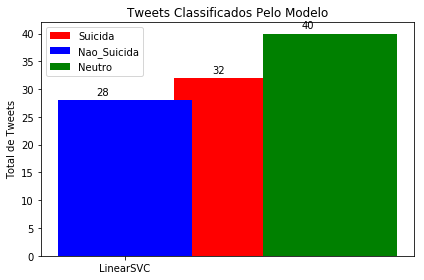

In [38]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt

# Visualização dos resultados de forma gráfica
modelos  = ['LinearSVC']
positivo = [conta_positiva]
negativo = [conta_negativa]
neutro = [conta_neutra]
x = np.arange(len(positivo))
 
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3 + 0.30, positivo, width, label='Suicida', color = 'r')
rects2 = ax.bar(x , negativo, width, label='Nao_Suicida', color = 'b' )
rects3 = ax.bar(x + width/3 + 0.30, neutro, width, label='Neutro', color = 'g' )
ax.set_ylabel('Total de Tweets')
ax.set_title('Tweets Classificados Pelo Modelo')
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend()
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 3, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
fig.tight_layout()
plt.show()

In [39]:
print('*** A C A B E I ***')

*** A C A B E I ***
